In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install --upgrade category_encoders
# !pip install squarify

reference: https://www.kaggle.com/code/ekrembayar/store-item-demand-forecasting-with-lgbm/notebook

### definition


*   rolling mean: Choose a rolling window size, m, i.e., the number of consecutive observation per rolling window. 
*   Lead and Lag is used to shift one variable ahead or back in time so that the movements of two variables are more closely aligned if there is a time lag between a change in one variable and its impact on another.
*   LGBM: Tree based gradient boosting method
*   List item





In [ ]:
#data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

#preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

#model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#encoding
import category_encoders as ce

#LSTM
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU,Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

Using TensorFlow backend.


In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Data Import

In [ ]:
df = pd.read_csv('osp_cube_vansales_raw copy.csv', sep = ',')

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14355230 entries, 0 to 14355229
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   customercode     object 
 1   customername     object 
 2   invoicenumber    object 
 3   invoice_date     object 
 4   productcode      int64  
 5   productnameth    object 
 6   baseqty          int64  
 7   grossamount      float64
 8   netamount        float64
 9   groupnamelevel1  object 
 10  groupnamelevel2  object 
 11  groupnamelevel3  object 
 12  dc_code          object 
 13  dc_name          object 
 14  regionname       object 
 15  customertype     object 
 16  districtname     object 
 17  provincename     object 
 18  salesmancode     object 
 19  latitude         object 
 20  longitude        object 
 21  ProvinceNameEng  object 
dtypes: float64(2), int64(2), object(18)
memory usage: 2.4+ GB


In [ ]:
df.head(3)

,customercode,customername,invoicenumber,invoice_date,productcode,productnameth,baseqty,grossamount,netamount,groupnamelevel1,...,dc_code,dc_name,regionname,customertype,districtname,provincename,salesmancode,latitude,longitude,ProvinceNameEng
0,XYZ001687,ร้านแม่กำไร,HSV43C04358,2022-08-07,10000600,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,50,490.98,485.98,M-150,...,XYZ,เจทีเอ็ม อิมปอร์ต เอ๊กซ์ปอร์ต,LNO,โชว์ห่วยเล็ก (Community),อ.อุ้มผาง,จ.ตาก,XYZV03,16.067354,98.766893,Tak
1,OWK002779,ร้านเบญไข่ไก่-ข้าวสาร(หนองพลับ,HSX65C01536,2022-03-09,10000604,ซี-วิท ทับทิม 140 มล. 1x3x10,10,126.28,124.62,C-VITT,...,OWK,อ.วัฒนา (2018),CW,โชว์ห่วยเล็ก (Community),อ.หัวหิน,จ.ประจวบคีรีขันธ์,OWKO01,12.588834,99.735069,Prachuap Khiri Khan
2,PYD000698,???้าน อารีย์,HSU21C00865,2022-03-09,10000566,เอ็มเกลือแร่ 250มล เหลือง 1x24,6,47.73,46.73,M-ELECTROLYTE,...,PYD,ภิญโญ ดิสทริบิวชั่น,USO,โชว์ห่วยเล็ก (Community),อ.ตะกั่วทุ่ง,จ.พังงา,PYDV01,8.256646,98.281321,Phang-nga


# Preprocessing

## Type Conversion & feature engineering

In [ ]:
# date conversion
# df['invoice_date'] = df['invoice_date'].astype('datetime64[ns]')
df['invoice_date'] = pd.to_datetime(df['invoice_date'],format='%Y-%m-%d')

# extract month from date
df['month'] = df['invoice_date'].dt.month
# df['month'] = df['month'].astype('category')

# convert product code to categorical
df['productcode'] = df['productcode'].astype('category')

# day of week
df['day_of_week'] = df['invoice_date'].dt.dayofweek

# quarter
df['quarter'] = df['invoice_date'].dt.quarter

# week of year
df['week_of_year'] = df['invoice_date'].dt.weekofyear

# day
df['day'] = df['invoice_date'].dt.day

# is it weekend
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
temp = df['invoice_date']    
temp2 = df.invoice_date.apply(applyer)
df['weekend'] = temp2

df.info()

<ipython-input-7-f53ee70c6e3e>:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['invoice_date'].dt.weekofyear


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14355230 entries, 0 to 14355229
Data columns (total 28 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   customername     object        
 2   invoicenumber    object        
 3   invoice_date     datetime64[ns]
 4   productcode      category      
 5   productnameth    object        
 6   baseqty          int64         
 7   grossamount      float64       
 8   netamount        float64       
 9   groupnamelevel1  object        
 10  groupnamelevel2  object        
 11  groupnamelevel3  object        
 12  dc_code          object        
 13  dc_name          object        
 14  regionname       object        
 15  customertype     object        
 16  districtname     object        
 17  provincename     object        
 18  salesmancode     object        
 19  latitude         object        
 20  longitude        object        
 21  ProvinceNameEng  object      

In [ ]:
df.head(3)

,customercode,customername,invoicenumber,invoice_date,productcode,productnameth,baseqty,grossamount,netamount,groupnamelevel1,...,salesmancode,latitude,longitude,ProvinceNameEng,month,day_of_week,quarter,week_of_year,day,weekend
0,XYZ001687,ร้านแม่กำไร,HSV43C04358,2022-08-07,10000600,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,50,490.98,485.98,M-150,...,XYZV03,16.067354,98.766893,Tak,8,6,3,31,7,1
1,OWK002779,ร้านเบญไข่ไก่-ข้าวสาร(หนองพลับ,HSX65C01536,2022-03-09,10000604,ซี-วิท ทับทิม 140 มล. 1x3x10,10,126.28,124.62,C-VITT,...,OWKO01,12.588834,99.735069,Prachuap Khiri Khan,3,2,1,10,9,0
2,PYD000698,???้าน อารีย์,HSU21C00865,2022-03-09,10000566,เอ็มเกลือแร่ 250มล เหลือง 1x24,6,47.73,46.73,M-ELECTROLYTE,...,PYDV01,8.256646,98.281321,Phang-nga,3,2,1,10,9,0


In [ ]:
minDate = df['invoice_date'].min()
maxDate = df['invoice_date'].max()

print("min date:",minDate)
print("max date:",maxDate)

min date: 2021-09-20 00:00:00
max date: 2022-09-19 00:00:00


In [ ]:
# check for null value in each col
df.isnull().mean() * 100

customercode       0.000000
customername       0.000864
invoicenumber      0.000000
invoice_date       0.000000
productcode        0.000000
productnameth      0.000000
baseqty            0.000000
grossamount        0.000000
netamount          0.000000
groupnamelevel1    0.000000
groupnamelevel2    0.000000
groupnamelevel3    0.000000
dc_code            0.000000
dc_name            0.000000
regionname         0.000000
customertype       0.000000
districtname       0.000000
provincename       0.000000
salesmancode       0.000418
latitude           0.024744
longitude          0.024228
ProvinceNameEng    0.229498
month              0.000000
day_of_week        0.000000
quarter            0.000000
week_of_year       0.000000
day                0.000000
weekend            0.000000
dtype: float64

In [ ]:
#train set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14355230 entries, 0 to 14355229
Data columns (total 28 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   customername     object        
 2   invoicenumber    object        
 3   invoice_date     datetime64[ns]
 4   productcode      category      
 5   productnameth    object        
 6   baseqty          int64         
 7   grossamount      float64       
 8   netamount        float64       
 9   groupnamelevel1  object        
 10  groupnamelevel2  object        
 11  groupnamelevel3  object        
 12  dc_code          object        
 13  dc_name          object        
 14  regionname       object        
 15  customertype     object        
 16  districtname     object        
 17  provincename     object        
 18  salesmancode     object        
 19  latitude         object        
 20  longitude        object        
 21  ProvinceNameEng  object      

In [ ]:
import datetime
from datetime import timedelta

full_train_start_day = minDate
full_train_end_day = maxDate

# data time range for validation split 
val_end_day = full_train_end_day
val_start_day = val_end_day - datetime.timedelta(days = 15)

# data time range for train
train_start_day = full_train_start_day 
train_end_day = val_end_day - datetime.timedelta(days = 16)

# data time range of test set
test_start_day = val_end_day + datetime.timedelta(days = 1)
test_end_day = test_start_day + datetime.timedelta(days = 15)

print('full_train_start_day',full_train_start_day)
print('full_train_start_day',full_train_end_day)
print('date duration:',(full_train_end_day - full_train_start_day).days, "\n")

print('train_start_day',train_start_day)
print('train_end_day',train_end_day)
print('date duration:',(train_end_day - train_start_day).days, "\n")

print('val_start_day',val_start_day)
print('val_end_day',val_end_day)
print('date duration:',(val_end_day - val_start_day).days, "\n")

print('test_start_day',test_start_day)
print('test_end_day',test_end_day)
print('date duration:',(test_end_day - test_start_day).days, "\n")

full_train_start_day 2021-09-20 00:00:00
full_train_start_day 2022-09-19 00:00:00
date duration: 364 

train_start_day 2021-09-20 00:00:00
train_end_day 2022-09-03 00:00:00
date duration: 348 

val_start_day 2022-09-04 00:00:00
val_end_day 2022-09-19 00:00:00
date duration: 15 

test_start_day 2022-09-20 00:00:00
test_end_day 2022-10-05 00:00:00
date duration: 15 



## Drop Column

In [ ]:
def dropCol(df):
    df = df.drop(columns=['latitude','longitude','productcode','dc_name','ProvinceNameEng','grossamount','customername','netamount'])

  # #check and remove duplicate
  # print("total rows in dataframe",len(df))
  # duplicatedRowCount = df.duplicated(subset=None, keep='first').sum()
  # print('removing ', duplicatedRowCount ," rows")
  # print("remaining rows:",len(df) - duplicatedRowCount)
    return df

df_1 = dropCol(df)

In [ ]:
#drop rows with 0 values
df_2 = df_1.loc[~((df_1['baseqty'] == 0))]
# check if dropped 
df_2.loc[df_2['baseqty'] == 0] 

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,customertype,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend


In [ ]:
df_2.describe()

,baseqty,month,day_of_week,quarter,week_of_year,day,weekend
count,1.420421e+07,1.420421e+07,1.420421e+07,1.420421e+07,1.420421e+07,1.420421e+07,1.420421e+07
mean,2.813482e+01,6.595528e+00,2.539900e+00,2.528519e+00,2.661817e+01,1.575062e+01,1.756021e-01
std,8.748923e+01,3.393304e+00,1.749545e+00,1.098285e+00,1.471396e+01,8.520460e+00,3.804813e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+01,4.000000e+00,1.000000e+00,2.000000e+00,1.400000e+01,8.000000e+00,0.000000e+00
50%,1.000000e+01,7.000000e+00,3.000000e+00,3.000000e+00,2.700000e+01,1.600000e+01,0.000000e+00
75%,2.000000e+01,9.000000e+00,4.000000e+00,3.000000e+00,3.900000e+01,2.300000e+01,0.000000e+00
max,8.005000e+04,1.200000e+01,6.000000e+00,4.000000e+00,5.200000e+01,3.100000e+01,1.000000e+00


# EDA

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='baseqty', ylabel='Density'>

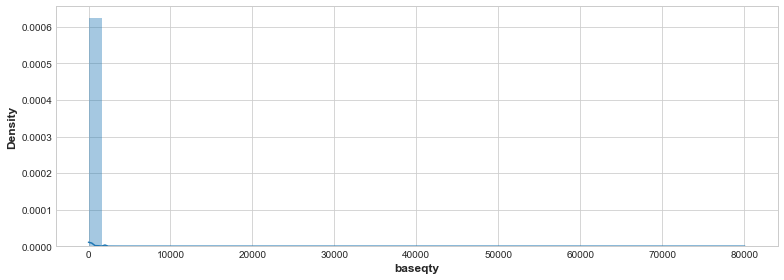

In [ ]:
sns.distplot(df_2["baseqty"])

Text(0, 0.5, 'baseqty')

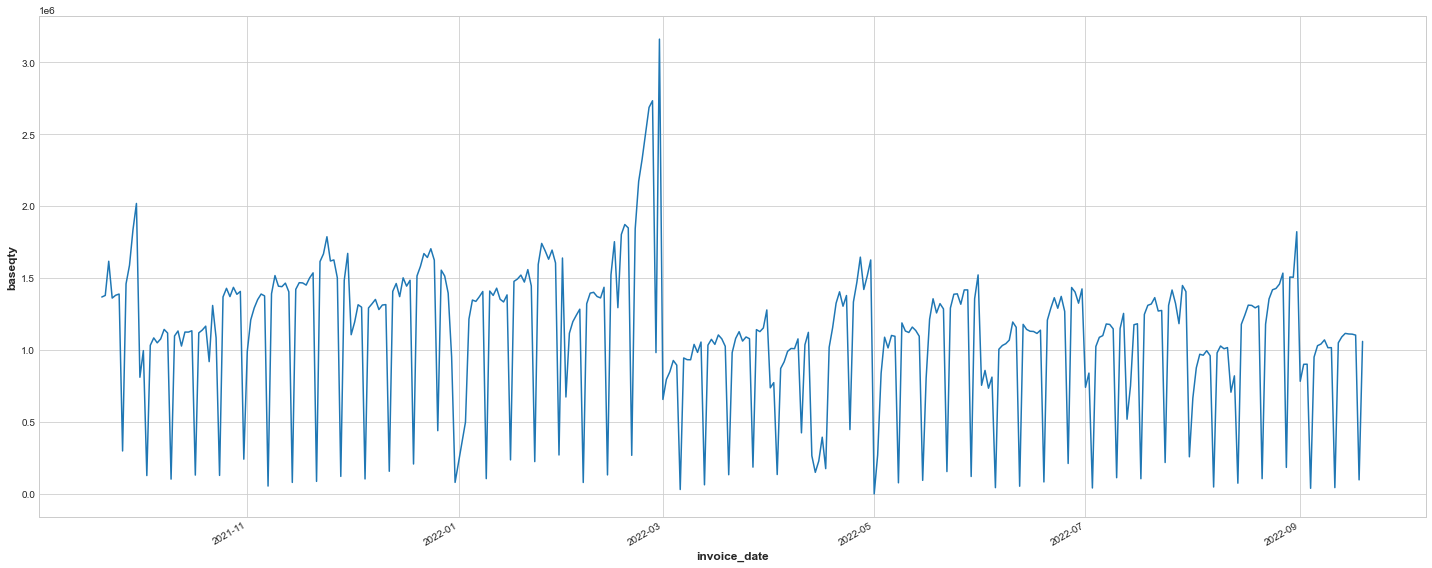

In [ ]:
# baseqty by date
df_2.groupby('invoice_date').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("invoice_date")
plt.ylabel("baseqty")

Text(0, 0.5, 'baseqty')

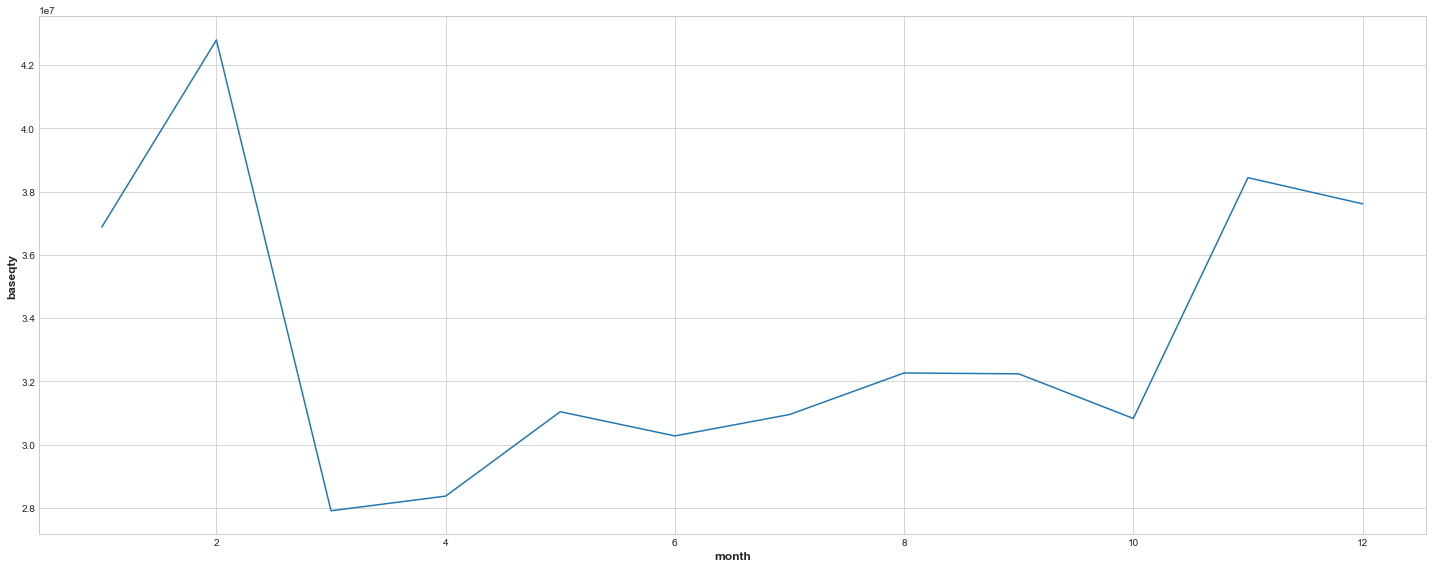

In [ ]:
# baseqty by month
df_2.groupby('month').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("month")
plt.ylabel("baseqty")

Text(0, 0.5, 'baseqty')

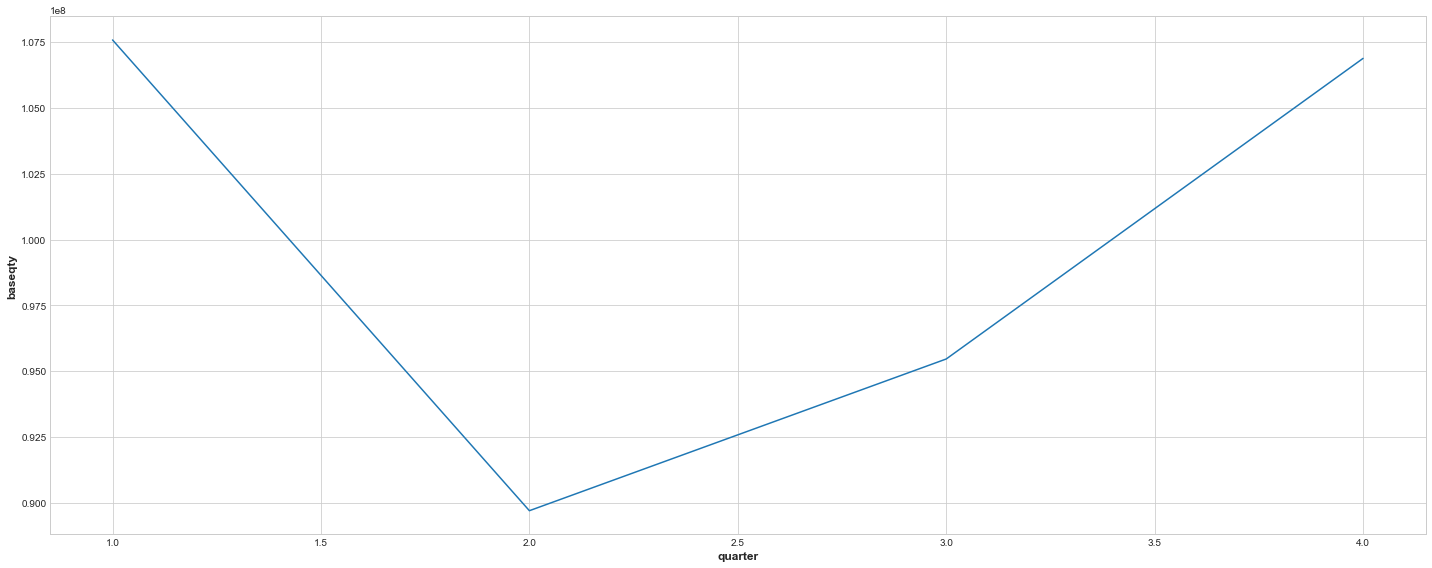

In [ ]:
# baseqty by quarter
df_2.groupby('quarter').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("quarter")
plt.ylabel("baseqty")

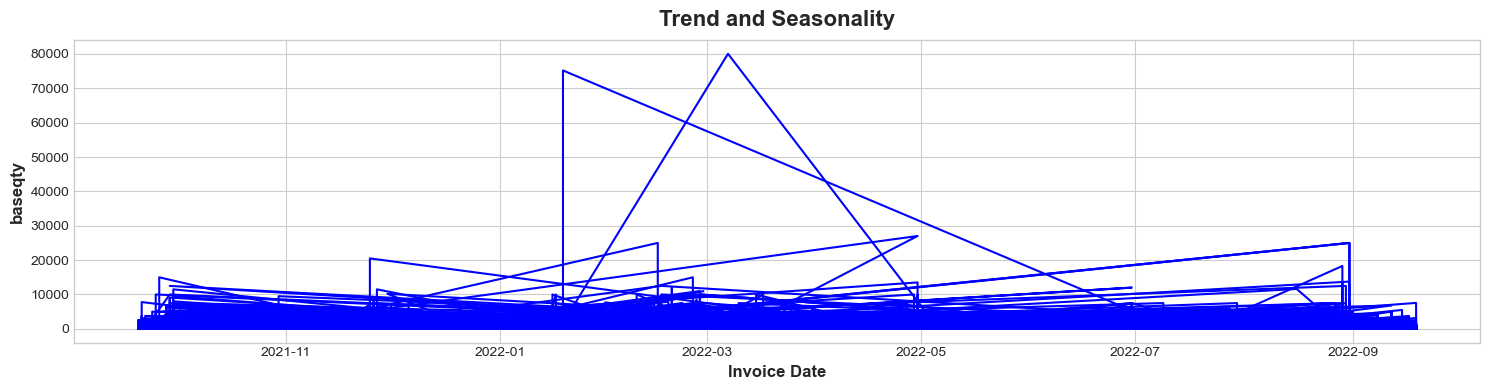

In [ ]:
#seasonality check 
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

def plot_df(df, x, y, title="", xlabel='Invoice Date', ylabel='baseqty', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df_2, x=df_2['invoice_date'], y=df_2['baseqty'], title='Trend and Seasonality')
# no seasonality 

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204212 entries, 0 to 14355229
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   invoicenumber    object        
 2   invoice_date     datetime64[ns]
 3   productnameth    object        
 4   baseqty          int64         
 5   groupnamelevel1  object        
 6   groupnamelevel2  object        
 7   groupnamelevel3  object        
 8   dc_code          object        
 9   regionname       object        
 10  customertype     object        
 11  districtname     object        
 12  provincename     object        
 13  salesmancode     object        
 14  month            int64         
 15  day_of_week      int64         
 16  quarter          int64         
 17  week_of_year     int64         
 18  day              int64         
 19  weekend          int64         
dtypes: datetime64[ns](1), int64(7), object(12)
memory usage: 2.2+ GB


Text(0.5, 1.0, 'Quantity sold per month for province')

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current fon

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 3591 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 3648 missing from current font.
  fon

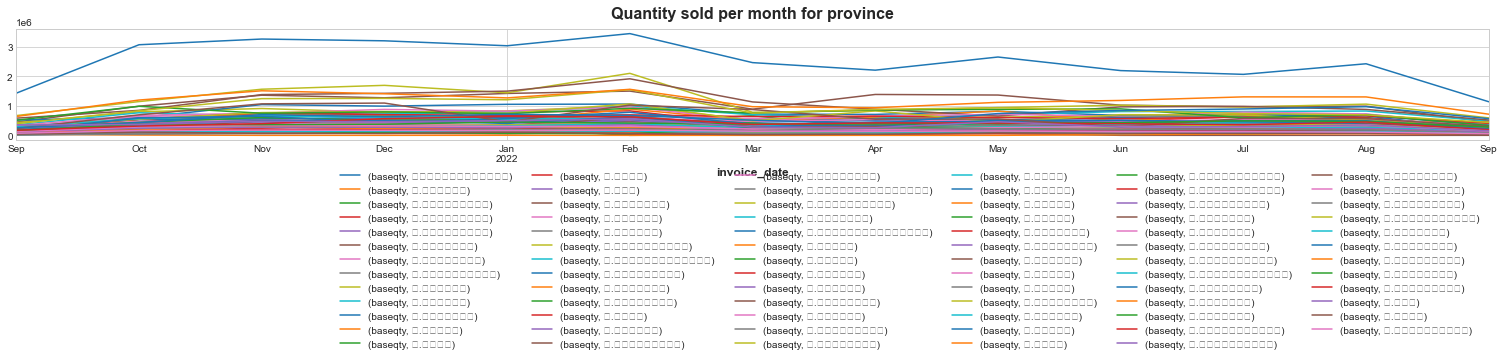

In [ ]:
# reorganise data, group by store, date, productname
df_province_monthly_sales = (df_2.groupby(['invoice_date', 'provincename']).aggregate({'baseqty': 'sum'}).unstack().resample('1M').sum())

df_province_monthly_sales.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Quantity sold per month for province")

<AxesSubplot:xlabel='month'>

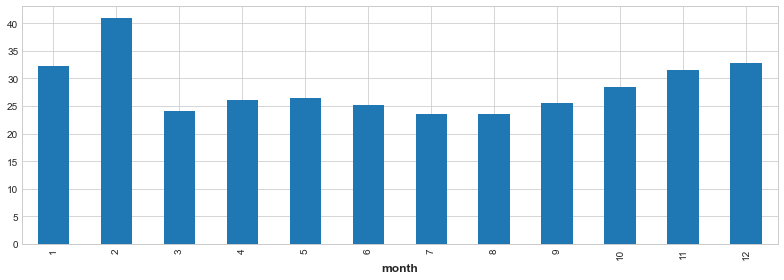

In [ ]:
df_2.groupby('month')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='weekend'>

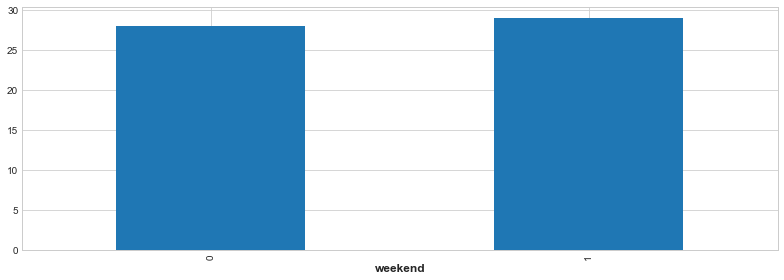

In [ ]:
df_2.groupby('weekend')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='day'>

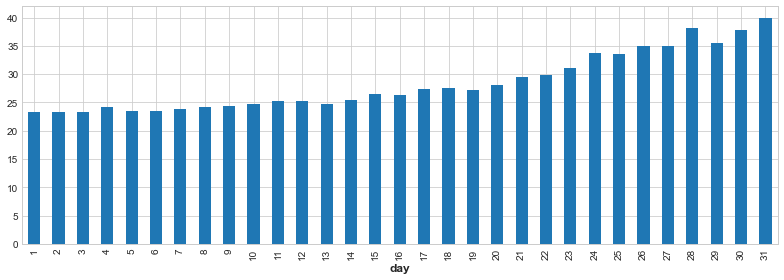

In [ ]:
df_2.groupby('day')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='week_of_year'>

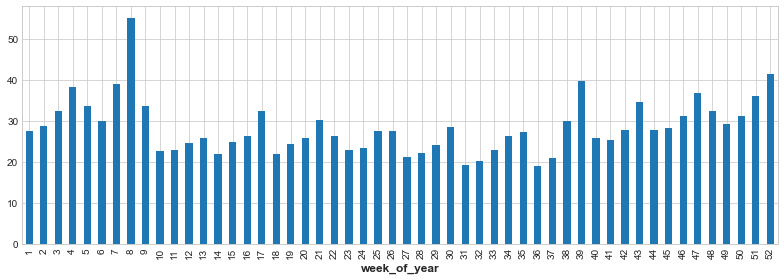

In [ ]:
# week_of_year
df_2.groupby('week_of_year')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='day_of_week'>

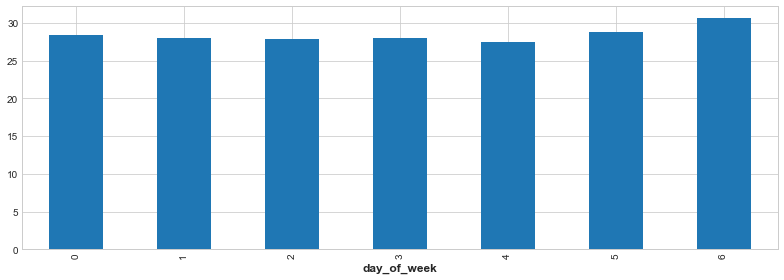

In [ ]:
df_2.groupby('day_of_week')['baseqty'].mean().plot.bar()

In [ ]:
df_3 = df_2.copy()
df_3.head()

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,customertype,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend
0,XYZ001687,HSV43C04358,2022-08-07,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,50,M-150,ENERGY DRINK,REGULAR,XYZ,LNO,โชว์ห่วยเล็ก (Community),อ.อุ้มผาง,จ.ตาก,XYZV03,8,6,3,31,7,1
1,OWK002779,HSX65C01536,2022-03-09,ซี-วิท ทับทิม 140 มล. 1x3x10,10,C-VITT,REFRESHMENT,VITAMIN,OWK,CW,โชว์ห่วยเล็ก (Community),อ.หัวหิน,จ.ประจวบคีรีขันธ์,OWKO01,3,2,1,10,9,0
2,PYD000698,HSU21C00865,2022-03-09,เอ็มเกลือแร่ 250มล เหลือง 1x24,6,M-ELECTROLYTE,SPORT DRINK,REGULAR,PYD,USO,โชว์ห่วยเล็ก (Community),อ.ตะกั่วทุ่ง,จ.พังงา,PYDV01,3,2,1,10,9,0
3,MTM001410,HSB83C01097,2022-03-09,ฉลาม กระชายดำ 100ML 1x5x10,10,CHALARM,ENERGY DRINK,REGULAR,MTM,USO,อื่นๆ,อ.เขาพนม,จ.กระบี่,MTMV03,3,2,1,10,9,0
4,OWK000572,HSX65C01530,2022-03-09,เอ็ม-150 กระชายดำ LT 100มล. 1x5x10,10,M-150,ENERGY DRINK,REGULAR,OWK,CW,โชว์ห่วยเล็ก (Community),อ.หัวหิน,จ.ประจวบคีรีขันธ์,OWKV01,3,2,1,10,9,0


In [ ]:
df_4 = df_3[['provincename','invoice_date','productnameth','baseqty','customercode','salesmancode','dc_code','invoicenumber']]
df_4['invoice_date'] = df_4.invoice_date.dt.to_period('D')
df_4 = df_4.set_index(['provincename', 'invoice_date', 'productnameth']).groupby(['provincename', 'invoice_date', 'productnameth']).agg({'baseqty': 'sum','customercode':'nunique','salesmancode':'nunique','dc_code':'nunique','invoicenumber':'count'}).rename(columns={'baseqty':'baseqty','customercode':'no_of_selling_pt','salesmancode':'no_of_salesman','dc_code':'no_of_dc','invoicenumber':'no_of_invoice_count'}).sort_index()
df_4.head(30)

<ipython-input-29-f39d0204f8d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['invoice_date'] = df_4.invoice_date.dt.to_period('D')


baseqty  \
provincename  invoice_date productnameth                                         
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8            88   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM             6   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM               99   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6           48   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        104   
                           คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6             342   
                           คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6           198   
                           คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6        288   
                           ฉลาม กระชายดำ 100ML 1x5x10                      240   
                           ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10           370   
                           ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10           4390   
                           ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4              20   
                           ซี-วิต วิตามินเลมอน 125มล. 1x9x4                 44   
                           ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10         7140   
                           ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10            6070   
                           ยันฮี วิตามิน วอเตอร์ 460ML 1x12               3096   
                           ยันฮี วิตามิน วอเตอร์ 750ML 1x12                 12   
                           ลิโพ-ไฟน์ 100มล 1X5X10                          205   
                           ลิโพวิตัน-ดี 100มล 1X5X10                     18010   
                           เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8        3   
                           เปปทีน พลัส BT 100ML 1x4x6 INNER SBM             48   
                           เปปทีน4000 BT 100ML 1x4x6 INNER SBM              12   
                           เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10      87300   
                           เอ็ม-150  กระชายดำ LT 100มล. 1x5x10            1560   
                           เอ็มเกลือแร่ 250มล. ขาว (1x24)                  876   
                           เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         1128   
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)            1190   
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10          615   
              2021-09-21   คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM           36   
                           คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8            88   

                                                                       no_of_selling_pt  \
provincename  invoice_date productnameth                                                  
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8                      9   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM                      1   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM                        10   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6                    12   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8                  11   
                           คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6                       57   
                           คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6                     16   
                           คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6                  34   
                           ฉลาม กระชายดำ 100ML 1x5x10                                21   
                           ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10                     26   
                           ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10                     386   
                           ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4                        3   
                           ซี-วิต วิตามินเลมอน 125มล. 1x9x4                           4   
                           ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10                

In [ ]:
df_4.loc['จ.แม่ฮ่องสอน', :].tail(30)

baseqty  \
invoice_date productnameth                                     
2022-09-15   ลิโพวิตัน-ดี ราฟเฟิล2022 100มล 1X5X10       280   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10       740   
             เอ็ม-150 เทอร์ปีน 150มล. 1x5x10             590   
             เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10      1340   
             เอ็ม-150  กระชายดำ BK 100มล. 1x5x10         310   
             เอ็มสปอร์ต เหลือง 250มล. (1x4x6)            324   
             โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         320   
             โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10       20   
2022-09-16   คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6        6   
             ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10       110   
             ซี-วิท ออเร้นจ์ 10ปี 140มล 1x3x10            70   
             ซี-วิท เลมอน 10ปี 140มล 1x3x10              130   
             ยันฮี น้ำกัญชา 460มล 1x12                    12   
             ยันฮี วิตามิน วอเตอร์ 460ML 1x12             12   
             ลิโพวิตัน-ดี ราฟเฟิล2022 100มล 1X5X10        70   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10       400   
             เอ็ม-150 เทอร์ปีน 150มล. 1x5x10             320   
             เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10      2240   
             เอ็ม-150  กระชายดำ BK 100มล. 1x5x10         320   
             เอ็มสปอร์ต เหลือง 250มล. (1x4x6)            222   
             โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         150   
2022-09-17   คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM        48   
             ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10        20   
             ซี-วิท ออเร้นจ์ 10ปี 140มล 1x3x10           150   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10       210   
             เอ็ม-150 เทอร์ปีน 150มล. 1x5x10             210   
             เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10       940   
             เอ็ม-150  กระชายดำ BK 100มล. 1x5x10         210   
             เอ็มสปอร์ต เหลือง 250มล. (1x4x6)            114   
             โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         200   

                                                     no_of_selling_pt  \
invoice_date productnameth                                              
2022-09-15   ลิโพวิตัน-ดี ราฟเฟิล2022 100มล 1X5X10                 28   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10                 41   
             เอ็ม-150 เทอร์ปีน 150มล. 1x5x10                       35   
             เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10                 35   
             เอ็ม-150  กระชายดำ BK 100มล. 1x5x10                   31   
             เอ็มสปอร์ต เหลือง 250มล. (1x4x6)                      16   
             โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)                   32   
             โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10                 2   
2022-09-16   คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6                 1   
             ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10                 11   
             ซี-วิท ออเร้นจ์ 10ปี 140มล 1x3x10                      7   
             ซี-วิท เลมอน 10ปี 140มล 1x3x10                        12   
             ยันฮี น้ำกัญชา 460มล 1x12                              1   
             ยันฮี วิตามิน วอเตอร์ 460ML 1x12                       1   
             ลิโพวิตัน-ดี ราฟเฟิล2022 100มล 1X5X10                  7   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10                 39   
             เอ็ม-150 เทอร์ปีน 150มล. 1x5x10                       31   
             เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10                 35   
             เอ็ม-150  กระชายดำ BK 100มล. 1x5x10                   31   
             เอ็มสปอร์ต เหลือง 250มล. (1x4x6)                      27   
             โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)                   15   
2022-09-17   คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM                  4   
             ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10                  2   
             ซี-วิท ออเร้นจ์ 10ปี 140มล 1x3x10                     15   
             เอ็ม-150 น้ำผึ้ง 10 บาท 150มล. 1x5x10                 21   
             เอ็ม-150 เทอร์ปีน 15

In [ ]:
df_4.shape

(488147, 5)

In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 488147 entries, ('กรุงเทพมหานคร', Period('2021-09-20', 'D'), 'คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8') to ('จ.แม่ฮ่องสอน', Period('2022-09-17', 'D'), 'โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)')
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   baseqty              488147 non-null  int64
 1   no_of_selling_pt     488147 non-null  int64
 2   no_of_salesman       488147 non-null  int64
 3   no_of_dc             488147 non-null  int64
 4   no_of_invoice_count  488147 non-null  int64
dtypes: int64(5)
memory usage: 20.5+ MB


In [ ]:
X_train9 = df_4.copy()

# Splitting Data to train/val/test

In [ ]:
X_train10 = X_train9.unstack(['provincename', 'productnameth']).loc[full_train_start_day:full_train_end_day]
X_train11 = X_train10.fillna(0)
X_train11

baseqty  \
provincename                          กรุงเทพมหานคร   
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date                                          
2021-09-20                                     88.0   
2021-09-21                                     88.0   
2021-09-22                                    104.0   
2021-09-23                                     72.0   
2021-09-24                                     48.0   
...                                             ...   
2022-09-15                                      8.0   
2022-09-16                                      8.0   
2022-09-17                                      8.0   
2022-09-18                                      0.0   
2022-09-19                                      8.0   

                                                     \
provincename                                          
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date                                          
2021-09-20                                      6.0   
2021-09-21                                     36.0   
2021-09-22                                     24.0   
2021-09-23                                     28.0   
2021-09-24                                      0.0   
...                                             ...   
2022-09-15                                     48.0   
2022-09-16                                    123.0   
2022-09-17                                     75.0   
2022-09-18                                      0.0   
2022-09-19                                     12.0   

                                                  \
provincename                                       
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date                                       
2021-09-20                                  99.0   
2021-09-21                                  36.0   
2021-09-22                                  36.0   
2021-09-23                                 102.0   
2021-09-24                                  96.0   
...                                          ...   
2022-09-15                                  42.0   
2022-09-16                                 114.0   
2022-09-17                                  90.0   
2022-09-18                                   0.0   
2022-09-19                                  66.0   

                                                      \
provincename                                           
productnameth คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
invoice_date                                           
2021-09-20                                      48.0   
2021-09-21                                      24.0   
2021-09-22                                      84.0   
2021-09-23                                      18.0   
2021-09-24                                       6.0   
...                                              ...   
2022-09-15                                       0.0   
2022-09-16                                       0.0   
2022-09-17                                       0.0   
2022-09-18                                       0.0   
2022-09-19                                       0.0   

                                                        \
provincename                                             
productnameth คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8   
invoice_date                                             
2021-09-20                                       104.0   
2021-09-21                                       104.0   
2021-09-22                                        72.0   
2021-09-23                                       160.0   
2021-09-24                                        56.0   
...                                                ...   
2022-09-15                                         0.0   
2022-09-16                                         0.0   
2022-09-17                                         0.0   
2022-09-18      

In [ ]:
# # standardize
# def standardize(df):
    
#     scaler = MinMaxScaler()
#     cols = df.columns
#     idx = df.index

#     # transform data
#     scaled = scaler.fit_transform(df)
#     df = pd.DataFrame(scaled, columns=cols,index = idx)
#     return df

# X_train11 = standardize(X_train11)

## Create and concat test dataset (next 16 days)

In [ ]:
new_index = pd.date_range(test_start_day, test_end_day)
new_index = new_index.to_period('D')
df_test = pd.DataFrame(np.nan, index=new_index, columns=X_train11.columns)
df_test = pd.DataFrame(0, index=new_index, columns=X_train11.columns)
df_test.index.name = 'invoice_date'
df_test

baseqty  \
provincename                          กรุงเทพมหานคร   
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date                                          
2022-09-20                                        0   
2022-09-21                                        0   
2022-09-22                                        0   
2022-09-23                                        0   
2022-09-24                                        0   
2022-09-25                                        0   
2022-09-26                                        0   
2022-09-27                                        0   
2022-09-28                                        0   
2022-09-29                                        0   
2022-09-30                                        0   
2022-10-01                                        0   
2022-10-02                                        0   
2022-10-03                                        0   
2022-10-04                                        0   
2022-10-05                                        0   

                                                     \
provincename                                          
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date                                          
2022-09-20                                        0   
2022-09-21                                        0   
2022-09-22                                        0   
2022-09-23                                        0   
2022-09-24                                        0   
2022-09-25                                        0   
2022-09-26                                        0   
2022-09-27                                        0   
2022-09-28                                        0   
2022-09-29                                        0   
2022-09-30                                        0   
2022-10-01                                        0   
2022-10-02                                        0   
2022-10-03                                        0   
2022-10-04                                        0   
2022-10-05                                        0   

                                                  \
provincename                                       
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date                                       
2022-09-20                                     0   
2022-09-21                                     0   
2022-09-22                                     0   
2022-09-23                                     0   
2022-09-24                                     0   
2022-09-25                                     0   
2022-09-26                                     0   
2022-09-27                                     0   
2022-09-28                                     0   
2022-09-29                                     0   
2022-09-30                                     0   
2022-10-01                                     0   
2022-10-02                                     0   
2022-10-03                                     0   
2022-10-04                                     0   
2022-10-05                                     0   

                                                      \
provincename                                           
productnameth คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
invoice_date                                           
2022-09-20                                         0   
2022-09-21                                         0   
2022-09-22                                         0   
2022-09-23                                         0   
2022-09-24                                         0   
2022-09-25                                         0   
2022-09-26                                         0   
2022-09-27                                         0   
2022-09-28                                         0   
2022-09-29                                         0   
2022-09-30       

In [ ]:
final_dataset = pd.concat([X_train11,df_test])
final_dataset.tail(30)

baseqty  \
provincename                          กรุงเทพมหานคร   
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date                                          
2022-09-06                                      8.0   
2022-09-07                                      8.0   
2022-09-08                                      0.0   
2022-09-09                                      0.0   
2022-09-10                                     16.0   
2022-09-11                                      0.0   
2022-09-12                                      0.0   
2022-09-13                                      0.0   
2022-09-14                                      8.0   
2022-09-15                                      8.0   
2022-09-16                                      8.0   
2022-09-17                                      8.0   
2022-09-18                                      0.0   
2022-09-19                                      8.0   
2022-09-20                                      0.0   
2022-09-21                                      0.0   
2022-09-22                                      0.0   
2022-09-23                                      0.0   
2022-09-24                                      0.0   
2022-09-25                                      0.0   
2022-09-26                                      0.0   
2022-09-27                                      0.0   
2022-09-28                                      0.0   
2022-09-29                                      0.0   
2022-09-30                                      0.0   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                     \
provincename                                          
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date                                          
2022-09-06                                     60.0   
2022-09-07                                     72.0   
2022-09-08                                    177.0   
2022-09-09                                    132.0   
2022-09-10                                    105.0   
2022-09-11                                      6.0   
2022-09-12                                     66.0   
2022-09-13                                     42.0   
2022-09-14                                     30.0   
2022-09-15                                     48.0   
2022-09-16                                    123.0   
2022-09-17                                     75.0   
2022-09-18                                      0.0   
2022-09-19                                     12.0   
2022-09-20                                      0.0   
2022-09-21                                      0.0   
2022-09-22                                      0.0   
2022-09-23                                      0.0   
2022-09-24                                      0.0   
2022-09-25                                      0.0   
2022-09-26                                      0.0   
2022-09-27                                      0.0   
2022-09-28                                      0.0   
2022-09-29                                      0.0   
2022-09-30                                      0.0   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                  \
provincename                                       
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date                                       
2022-09-06                                 189.0   
2022-09-07                                

# LGBM

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [ ]:
def encode_categoricals(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):

    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="D") # freq adds i extra day(s) to end: only one extra day is needed so rest will be dropped
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('invoice_date').sort_values(by=stack_cols) # return sorted so can correctly compute rolling means (if desired)
    return df

In [ ]:
# try
def shaping(df,stack_columns=None):
    stack_columns = ['provincename', 'productnameth']

    shifted_qty_df = make_X2_lags(df['baseqty'], lags=2, name='qty', stack_cols=stack_columns)
    shifted_qty_df['qty_mean_rolling_5'] = shifted_qty_df['qty_lag_1'].rolling(window=5, center=False).mean()
    shifted_qty_df['qty_median_rolling_10'] = shifted_qty_df['qty_lag_1'].rolling(window=10, center=False).median().fillna(method='bfill')
    shifted_qty_df['qty_median_rolling_15'] = shifted_qty_df['qty_lag_1'].rolling(window=15, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_week"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_week'])
    
    # extract month from date
    X2['month'] = X2.index.month
    X2 = encode_categoricals(df, ['month'])

#     # quarter
#     X2['quarter'] = X2.index.quarter
#     X2 = encode_categoricals(df, ['quarter'])

    # week of year
    X2['week_of_year'] = X2.index.weekofyear
    X2 = encode_categoricals(df, ['week_of_year'])

    # day
    X2['day'] = X2.index.day
    X2 = encode_categoricals(df, ['day'])
    
#     # weekend
#     X2['is_weekend'] = X2['day_of_week'].isin([5,6])
    
    X2 = X2.merge(shifted_qty_df, on=['invoice_date', 'provincename', 'productnameth'], how='left')
    
    # standardize 
#     X2 = standardize(X2)

    return X2

In [ ]:
X_2 = shaping(final_dataset.stack(['provincename','productnameth']))
X_2 = X_2.fillna(0)

# full train
full_train = X_2.loc[full_train_start_day:full_train_end_day]

# setting up train
train = X_2.loc[train_start_day:train_end_day]
X_train = train.loc[:, train.columns != 'baseqty']
Y_train = train['baseqty']

# setting up validation
validation = X_2.loc[val_start_day:val_end_day]
X_validation = validation.loc[:, validation.columns != 'baseqty']
Y_validation = validation['baseqty']

# setting up test
test = X_2.loc[test_start_day:test_end_day]
X_test = test.loc[:, test.columns != 'baseqty']
Y_test = test['baseqty']

Y_train.shape, X_train.shape, Y_validation.shape, X_validation.shape

((1594812,), (1594812, 15), (73536,), (73536, 15))

In [ ]:
test

,provincename,productnameth,baseqty,no_of_dc,no_of_invoice_count,no_of_salesman,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date,,,,,,,,,,,,,,,,
2022-09-20,0,1,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,0.0,0.0,0.0
2022-09-20,0,3,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,0.0,0.0,0.0
2022-09-20,0,7,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,17.6,24.0,32.0
2022-09-20,0,8,0.0,0.0,0.0,0.0,0.0,1,8,37,19,6.0,0.0,8.4,6.0,6.0
2022-09-20,0,9,0.0,0.0,0.0,0.0,0.0,1,8,37,19,24.0,0.0,12.8,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-05,76,117,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0
2022-10-05,76,118,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0
2022-10-05,76,121,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0


In [ ]:
train

,provincename,productnameth,baseqty,no_of_dc,no_of_invoice_count,no_of_salesman,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date,,,,,,,,,,,,,,,,
2021-09-20,0,1,0.0,0.0,0.0,0.0,0.0,0,8,37,19,0.0,0.0,0.0,0.0,0.0
2021-09-20,0,3,0.0,0.0,0.0,0.0,0.0,0,8,37,19,0.0,0.0,0.0,0.0,0.0
2021-09-20,0,7,0.0,0.0,0.0,0.0,0.0,0,8,37,19,0.0,0.0,0.0,0.0,0.0
2021-09-20,0,8,0.0,0.0,0.0,0.0,0.0,0,8,37,19,0.0,0.0,0.0,0.0,0.0
2021-09-20,0,9,0.0,0.0,0.0,0.0,0.0,0,8,37,19,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-03,76,117,0.0,0.0,0.0,0.0,0.0,5,8,34,2,0.0,0.0,0.0,0.0,0.0
2022-09-03,76,118,0.0,0.0,0.0,0.0,0.0,5,8,34,2,0.0,0.0,0.0,0.0,0.0
2022-09-03,76,121,0.0,0.0,0.0,0.0,0.0,5,8,34,2,0.0,0.0,0.0,0.0,0.0


In [ ]:
import lightgbm as lgb
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_validation, first_model.predict(X_validation)))

TRAIN SMAPE: 153.62266696118422
VALID SMAPE: 151.99161302632675


In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                  feature  split       gain
13  qty_median_rolling_10    136  41.612650
3     no_of_invoice_count    318  15.688915
12     qty_mean_rolling_5    162  11.005512
10              qty_lag_1    313   8.426054
5        no_of_selling_pt    152   6.096916
14  qty_median_rolling_15    200   3.979649
4          no_of_salesman    217   3.248988
9                     day    378   2.907516
11              qty_lag_2    207   1.818919
8            week_of_year    207   1.518050
7                   month    158   1.272204
6             day_of_week    126   0.955610
0            provincename    219   0.691429
1           productnameth    155   0.576058
2                no_of_dc     52   0.201529


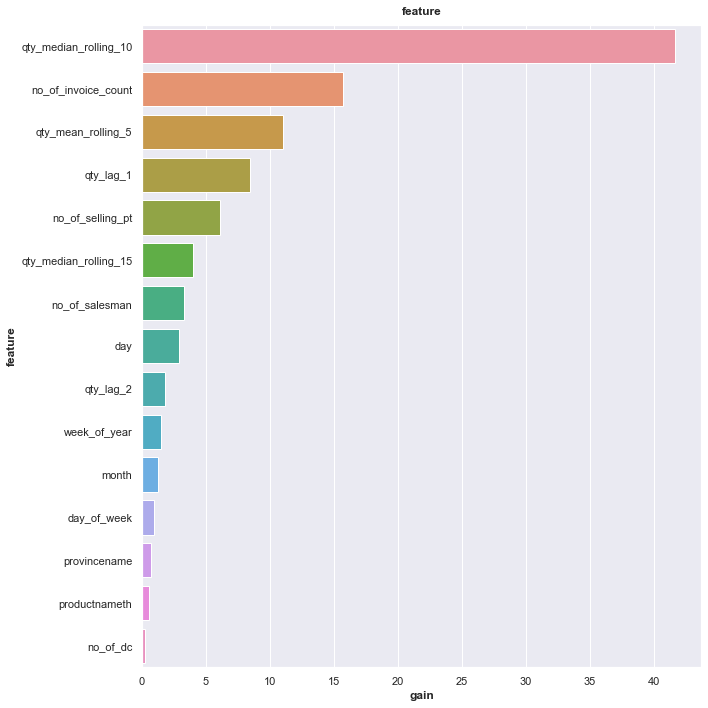

In [ ]:
plot_lgb_importances(first_model, plot=True, num=30)

In [ ]:
error = pd.DataFrame({
    "date":validation.index.get_level_values('invoice_date'),
    "provincename":X_validation.provincename,
    "productnameth":X_validation.productnameth,
    "actual":Y_validation,
    "pred":first_model.predict(X_validation)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)
error.sort_values("error", ascending=False).head(20)

,date,provincename,productnameth,actual,pred,error
46039,2022-09-14,0,107,53359.0,35079.534819,18279.465181
21403,2022-09-08,50,40,25930.0,7942.466708,17987.533292
20410,2022-09-08,33,40,19220.0,3532.563816,15687.436184
50615,2022-09-15,0,79,13420.0,27718.525092,14298.525092
29169,2022-09-10,25,107,32000.0,18678.869727,13321.130273
41614,2022-09-13,3,107,21250.0,8118.323087,13131.676913
50635,2022-09-15,0,107,26284.0,37607.217189,11323.217189
27635,2022-09-10,0,79,7320.0,18207.320182,10887.320182
40822,2022-09-12,67,78,10910.0,309.329651,10600.670349
41991,2022-09-13,9,78,11500.0,1164.920770,10335.079230


In [ ]:
error.groupby(["provincename", "productnameth"]).error.mean().sort_values(ascending = False)

provincename  productnameth
0             79               5462.484465
25            107              4313.420959
0             107              4119.217639
55            107              3011.549359
50            40               2828.569639
                                  ...     
64            68                  1.487459
49            11                  1.457832
50            11                  1.457832
28            67                  1.452447
71            10                  1.444551
Name: error, Length: 4596, dtype: float64

In [ ]:
error.groupby(["provincename"]).error.mean().sort_values(ascending = False)

provincename
0     203.539911
71    136.924207
2     136.325096
25    130.871686
70    130.457425
         ...    
38     25.938326
13     23.572838
75     22.855474
23     21.459468
15      1.873391
Name: error, Length: 77, dtype: float64

<AxesSubplot:xlabel='date'>

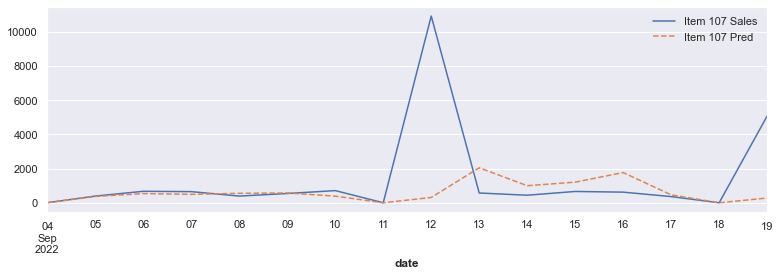

In [ ]:
sub = error[error.provincename == 67].set_index("date")
sub[sub.productnameth == 78].actual.plot(legend=True, label = "Item "+str(107)+" Sales")
sub[sub.productnameth == 78].pred.plot(legend=True, label="Item " + str(107) + " Pred", linestyle = "dashed")

In [ ]:
sub

,provincename,productnameth,actual,pred,error
date,,,,,
2022-09-04,67,8,0.0,1.873391,1.873391
2022-09-04,67,9,0.0,1.873391,1.873391
2022-09-04,67,10,0.0,1.873391,1.873391
2022-09-04,67,11,0.0,1.873391,1.873391
2022-09-04,67,16,0.0,1.873391,1.873391
...,...,...,...,...,...
2022-09-19,67,116,0.0,1.873391,1.873391
2022-09-19,67,117,0.0,1.873391,1.873391
2022-09-19,67,118,0.0,1.873391,1.873391


## Feature Selection

before feature selection:

TRAIN SMAPE: 154.94503908139677
VALID SMAPE: 153.03089040740352

In [ ]:
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_validation, second_model.predict(X_validation[cols])))

Independent Variables: 15
TRAIN SMAPE: 153.62266696118422
VALID SMAPE: 151.9916298028778


## Forecast

In [ ]:
error = pd.DataFrame({
    "date":validation.index.get_level_values('invoice_date'),
    "provincename":X_validation.provincename,
    "productnameth":X_validation.productnameth,
    "actual":Y_validation,
    "pred":first_model.predict(X_validation)
}).reset_index(drop = True)

In [ ]:
test

,provincename,productnameth,baseqty,no_of_dc,no_of_invoice_count,no_of_salesman,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date,,,,,,,,,,,,,,,,
2022-09-20,0,1,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,0.0,0.0,0.0
2022-09-20,0,3,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,0.0,0.0,0.0
2022-09-20,0,7,0.0,0.0,0.0,0.0,0.0,1,8,37,19,0.0,0.0,17.6,24.0,32.0
2022-09-20,0,8,0.0,0.0,0.0,0.0,0.0,1,8,37,19,6.0,0.0,8.4,6.0,6.0
2022-09-20,0,9,0.0,0.0,0.0,0.0,0.0,1,8,37,19,24.0,0.0,12.8,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-05,76,117,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0
2022-10-05,76,118,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0
2022-10-05,76,121,0.0,0.0,0.0,0.0,0.0,2,9,39,4,0.0,0.0,0.0,0.0,0.0


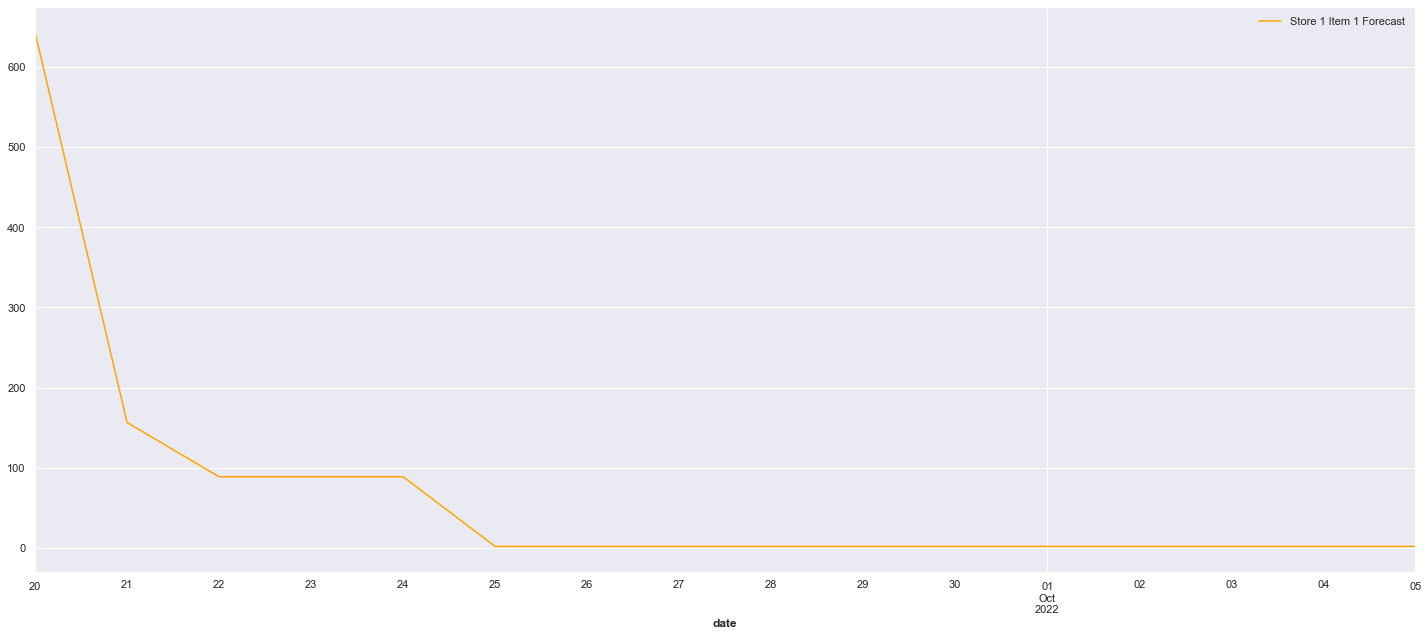

In [ ]:
forecast = pd.DataFrame({
    "date":test.index.get_level_values('invoice_date'),
    "provincename":test.provincename,
    "productnameth":test.productnameth,
    "baseqty":first_model.predict(X_test)
})

forecast[(forecast.provincename == 67) & (forecast.productnameth == 78)].set_index("date").baseqty.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

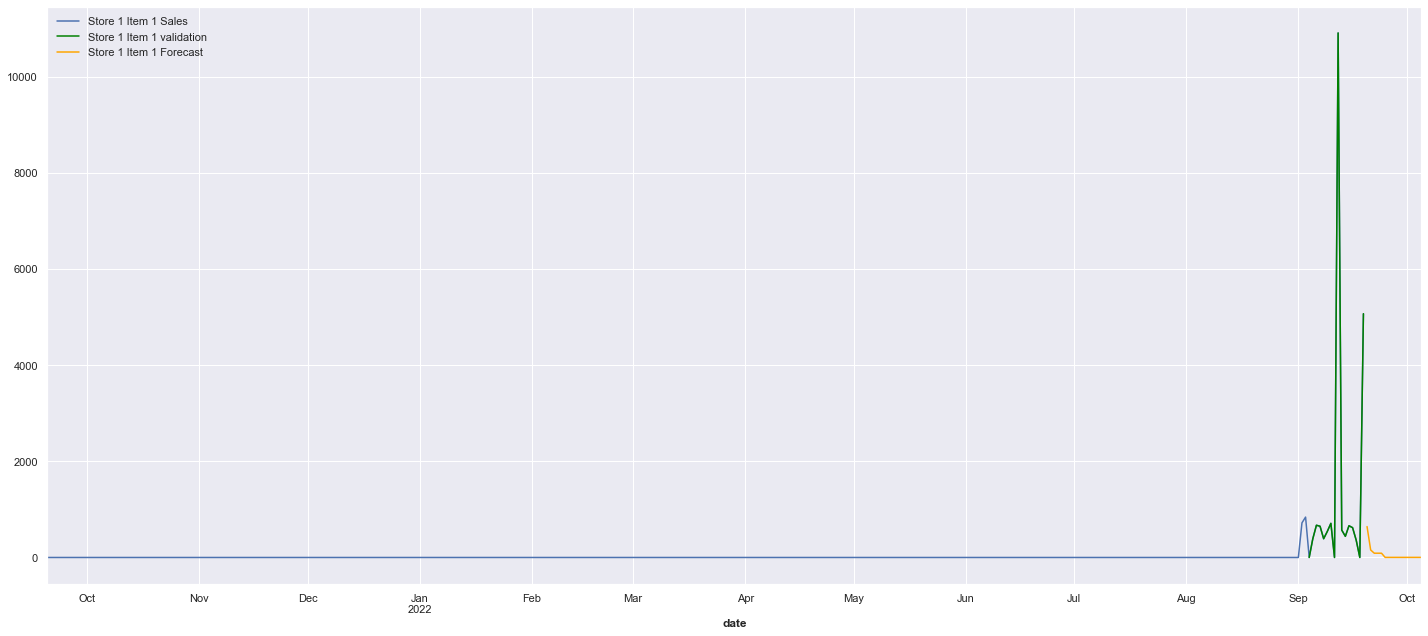

In [ ]:
full_train[(full_train.provincename == 67) & (full_train.productnameth == 78)].baseqty.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
validation[(validation.provincename == 67) & (validation.productnameth == 78)].baseqty.plot(color = "green", figsize = (20,9),legend=True, label = "Store 1 Item 1 validation")
forecast[(forecast.provincename == 67) & (forecast.productnameth == 78)].set_index("date").baseqty.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

# XGBOOST

# LINEAR + XGBOOST 

In [ ]:
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# pre-forecast setting
# lag- > moving the original data forward n period
max_lag = 0
mod_1 = LinearRegression()
mod_2 = XGBRegressor()

hybrid_forecasting_type = "direct" # possible values: day_by_day_refit_all_days, day_by_day_fixed_past, or direct

In [ ]:
# preparing hybrid model
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None

    def fit1(self, X_1, y, stack_cols=None):
        self.model_1.fit(X_1, y) # train model 1
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), # predict from model 1
            index=X_1.index,
            columns=y.columns,
        )
        self.y_resid = y - y_fit # residuals from model 1, which X2 may want to access to create lag (or other) features
        self.y_resid = self.y_resid.stack(stack_cols).squeeze()  # wide to long
        
    def predict(self, X_1, X_2, first_n_rows_to_ignore):
            y_pred = pd.DataFrame(
                self.model_1.predict(X_1),
                index=X_1.index,
                columns=self.y_columns,
            )
            y_pred = y_pred.stack(self.stack_cols).squeeze()
            y_pred += self.model_2.predict(X_2) # Add model_2 predictions to model_1 predictions
            return y_pred.unstack(self.stack_cols)
        
    def fit2(self, X_2, first_n_rows_to_ignore, stack_cols=None):
        self.model_2.fit(X_2, self.y_resid) # Train model_2
        self.y_columns = y.columns # Save for predict method
        self.stack_cols = stack_cols # Save for predict method

In [ ]:
# create X1 features
def make_dp_features(df):
    y = df.loc[:, 'baseqty']
    
    fourier_m = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        # seasonal=True, # note how this generates terms Tue - Sun: s(2,7) through s(7,7) (trend column: Monday)
        additional_terms=[fourier_m],
        drop=True,
    )
    return y, dp

def make_X1_features(df, start_date, end_date, is_test_set=False):

    if is_test_set:
        X1 = df.rename_axis('date')
    else:
        y, dp = make_dp_features(df)
        # seasonal (weekly) and fourier (longer time frame) features are generated using DeterministicProcess
        X1 = dp.in_sample() 
    
    if is_test_set:
        return X1
    else:
        return X1, y, dp

In [ ]:
def make_X2_features(df, y_resid,stack_columns=None):
    stack_columns = ['provincename', 'productnameth']

    # y_lag features
    shifted_y_df = make_X2_lags(y_resid, lags=2, name='y_res',stack_cols=stack_columns)
    shifted_y_df['y_mean_rolling_5'] = shifted_y_df['y_res_lag_1'].rolling(window=5, center=False).mean()
    shifted_y_df['y_median_rolling_10'] = shifted_y_df['y_res_lag_1'].rolling(window=10, center=False).median().fillna(method='bfill')
    shifted_y_df['y_median_rolling_15'] = shifted_y_df['y_res_lag_1'].rolling(window=15, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_week"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_week'])
    
    # extract month from date
    X2['month'] = X2.index.month
    X2 = encode_categoricals(df, ['month'])

    # quarter
    X2['quarter'] = X2.index.quarter
    X2 = encode_categoricals(df, ['quarter'])

    # week of year
    X2['week_of_year'] = X2.index.weekofyear
    X2 = encode_categoricals(df, ['week_of_year'])

    # day
    X2['day'] = X2.index.day
    X2 = encode_categoricals(df, ['day'])
    
    X2 = X2.merge(shifted_y_df, on=['invoice_date', 'provincename', 'productnameth'], how='left')

    return X2

In [ ]:
final_dataset

baseqty  \
provincename                          กรุงเทพมหานคร   
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date                                          
2021-09-20                                     88.0   
2021-09-21                                     88.0   
2021-09-22                                    104.0   
2021-09-23                                     72.0   
2021-09-24                                     48.0   
...                                             ...   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                     \
provincename                                          
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date                                          
2021-09-20                                      6.0   
2021-09-21                                     36.0   
2021-09-22                                     24.0   
2021-09-23                                     28.0   
2021-09-24                                      0.0   
...                                             ...   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                  \
provincename                                       
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date                                       
2021-09-20                                  99.0   
2021-09-21                                  36.0   
2021-09-22                                  36.0   
2021-09-23                                 102.0   
2021-09-24                                  96.0   
...                                          ...   
2022-10-01                                   0.0   
2022-10-02                                   0.0   
2022-10-03                                   0.0   
2022-10-04                                   0.0   
2022-10-05                                   0.0   

                                                      \
provincename                                           
productnameth คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
invoice_date                                           
2021-09-20                                      48.0   
2021-09-21                                      24.0   
2021-09-22                                      84.0   
2021-09-23                                      18.0   
2021-09-24                                       6.0   
...                                              ...   
2022-10-01                                       0.0   
2022-10-02                                       0.0   
2022-10-03                                       0.0   
2022-10-04                                       0.0   
2022-10-05                                       0.0   

                                                        \
provincename                                             
productnameth คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8   
invoice_date                                             
2021-09-20                                       104.0   
2021-09-21                                       104.0   
2021-09-22                                        72.0   
2021-09-23                                       160.0   
2021-09-24                                        56.0   
...                                                ...   
2022-10-01                                         0.0   
2022-10-02                                         0.0   
2022-10-03                                         0.0   
2022-10-04      

In [ ]:
model = BoostedHybrid(model_1=mod_1, model_2=mod_2) # Boosted Hybrid

X_1, y, dp = make_X1_features(final_dataset, full_train_start_day, full_train_end_day) 
model.fit1(X_1, y, stack_cols=['provincename', 'productnameth']) 

X_2 = make_X2_features(final_dataset.stack(['provincename','productnameth']), model.y_resid)
model.fit2(X_2, max_lag, stack_cols=['provincename','productnameth'])

In [ ]:
y_pred = model.predict(X_1, X_2, max_lag).clip(0.0) 

In [ ]:
def truncateFloat(data):
    return tuple( ["{0:.2f}".format(x) if isinstance(x,float) else (x if not isinstance(x,tuple) else truncateFloat(x)) for x in data])

temp = X_2[(X_2.provincename == 0) & (X_2.productnameth == 3)]
temp.iloc[max_lag: , :].apply(lambda s: truncateFloat(s)) # comment out next line if don't want to see nan rows

temp.apply(lambda s: truncateFloat(s)).head(10) # note that the fit method of BoostedHybrid class skips over nan rows                                    

,provincename,productnameth,baseqty,no_of_dc,no_of_invoice_count,no_of_salesman,no_of_selling_pt,day_of_week,month,quarter,week_of_year,day,y_res_lag_1,y_res_lag_2,y_mean_rolling_5,y_median_rolling_10,y_median_rolling_15
invoice_date,,,,,,,,,,,,,,,,,
2021-09-20,0,3,0.00,0.00,0.00,0.00,0.00,0,8,2,37,19,nan,nan,nan,nan,nan
2021-09-21,0,3,0.00,0.00,0.00,0.00,0.00,1,8,2,37,20,-1.72,nan,nan,-0.12,-1.04
2021-09-22,0,3,0.00,0.00,0.00,0.00,0.00,2,8,2,37,21,-0.18,-1.72,nan,-0.12,-1.04
2021-09-23,0,3,0.00,0.00,0.00,0.00,0.00,3,8,2,37,22,-0.78,-0.18,nan,-0.12,-1.04
2021-09-24,0,3,0.00,0.00,0.00,0.00,0.00,4,8,2,37,23,-0.06,-0.78,nan,-0.12,-1.04
2021-09-25,0,3,0.00,0.00,0.00,0.00,0.00,5,8,2,37,24,1.98,-0.06,-0.15,-0.12,-1.04
2021-09-26,0,3,0.00,0.00,0.00,0.00,0.00,6,8,2,37,25,1.36,1.98,0.47,-0.12,-1.04
2021-09-27,0,3,6.00,1.00,1.00,1.00,1.00,0,8,2,38,26,-1.04,1.36,0.29,-0.12,-1.04
2021-09-28,0,3,0.00,0.00,0.00,0.00,0.00,1,8,2,38,27,5.55,-1.04,1.56,-0.12,-1.04


In [ ]:
X_1.iloc[max_lag: , :].apply(lambda s: truncateFloat(s))

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
invoice_date,,,,,,,,,,,,,,,,
2021-09-20,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.74,-0.67,0.99,-0.10,-0.59,0.81,-0.21,-0.98
2021-09-21,1.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.87,-0.50,0.87,-0.50,-0.00,1.00,-0.87,-0.50
2021-09-22,1.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,-0.95,-0.31,0.59,-0.81,0.59,0.81,-0.95,0.31
2021-09-23,1.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,-0.99,-0.10,0.21,-0.98,0.95,0.31,-0.41,0.91
2021-09-24,1.00,5.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.99,0.10,-0.21,-0.98,0.95,-0.31,0.41,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,1.00,375.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
2022-10-02,1.00,376.00,0.00,0.00,0.00,1.00,0.00,0.00,0.20,0.98,0.39,0.92,0.57,0.82,0.72,0.69
2022-10-03,1.00,377.00,0.00,0.00,0.00,0.00,1.00,0.00,0.39,0.92,0.72,0.69,0.94,0.35,1.00,-0.05


/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3637 missing from current fon

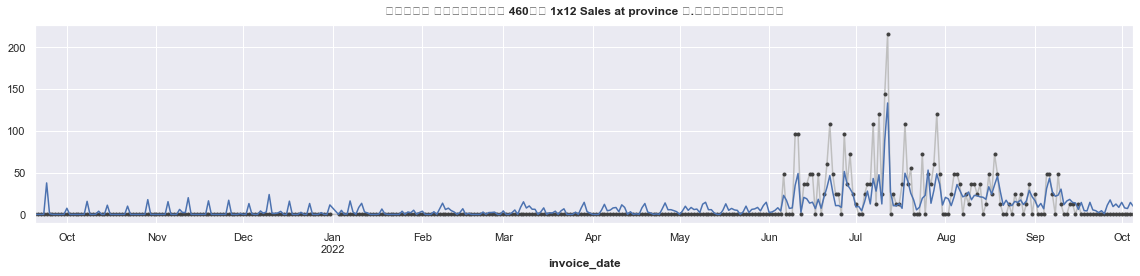

In [ ]:
provincename = 'จ.แม่ฮ่องสอน'  
productnameth = 'ยันฮี น้ำกัญชา 460มล 1x12' 

ax = y.loc(axis=1)[provincename, productnameth].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[provincename, productnameth].plot(ax=ax)
ax.set_title(f'{productnameth} Sales at province {provincename}');

## validation

In [ ]:
# validation
training_days = (train_end_day - train_start_day).days + 1
validation_days = (val_end_day - val_start_day).days + 1

print('date duration:',(train_end_day - train_start_day).days, "\n")
print("training data set (excluding validation days) has", training_days, "days")
print("validation data set has", validation_days, "days\n")

X_train11_v2 = final_dataset.loc[train_start_day:train_end_day]
X_train11_v2_val = final_dataset.loc[val_start_day:val_end_day]
y_val = y[val_start_day:val_end_day] # use y to evaluate validation set, though we will treat y as unknown when training

model_for_val = BoostedHybrid(model_1=mod_1, model_2=mod_2)

date duration: 348 

training data set (excluding validation days) has 349 days
validation data set has 16 days



In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import pickle

# X_1, y, dp = make_X1_features(X_train11, full_train_start_day, full_train_end_day) 
# model.fit1(X_1, y, stack_cols=['provincename', 'productnameth']) 

# X_2 = make_X2_features(X_train11.stack(['provincename','productnameth']), model.y_resid)
# model.fit2(X_2, max_lag, stack_cols=['provincename','productnameth'])

if hybrid_forecasting_type == "direct":
    
    X_1_train, y_train, dp_val = make_X1_features(X_train11_v2, train_start_day, train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_val.fit1(X_1_train, y_train, stack_cols=['provincename', 'productnameth']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    
    X_2_train = make_X2_features(X_train11_v2.stack(['provincename', 'productnameth']), model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['provincename', 'productnameth'])

    X_1_val = make_X1_features(dp_val.out_of_sample(steps=validation_days), val_start_day, val_end_day, is_test_set=True)
    X_2_val = make_X2_features(X_train11_v2_val.stack(['provincename', 'productnameth']), model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)
    y_pred = model_for_val.predict(X_1_val, X_2_val, 0).clip(0.0) # set max_lag to 0 because need entire time span for validation data set
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 



In [ ]:
from math import sqrt
rmsle_train = sqrt(mean_squared_error(y_train.iloc[max_lag:,:].clip(0.0), y_fit)) 
rmsle_valid = sqrt(mean_squared_error(y_val.clip(0.0), y_pred) )
print()
print(f'Training RMSE: {rmsle_train:.10f}')
print(f'Validation RMSE: {rmsle_valid:.10f}')
    
y_predict = y_pred.stack(['provincename', 'productnameth']).reset_index()
y_target = y_val.stack(['provincename', 'productnameth']).reset_index().copy()
y_target.rename(columns={y_target.columns[3]:'baseqty'},inplace=True)
y_target['baseqty_pred'] = y_predict[0].clip(0.0)

print('\nValidation RMSE by productnameth')
display(y_target.groupby('productnameth').apply(lambda r: sqrt(mean_squared_error(r['baseqty'], r['baseqty_pred']))))

print('\nValidation RMSE by provincename')
display(y_target.sort_values(by="provincename").groupby('provincename').apply(lambda r: sqrt(mean_squared_error(r['baseqty'], r['baseqty_pred']))))


Training RMSE: 2524.9772825239
Validation RMSE: 1673.6655993016

Validation RMSE by productnameth


productnameth
BMสบู่ก้อน ซากุระ 75ก. (แพ็ค 4) (1X12)      264.058946
BMแป้ง ซากุระ 50ก. (1x8x6)                  320.846712
BMแป้ง สวีทตี้พิงค์ 180ก. (3+1) 1X8         253.391830
BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)          305.952225
TPP แป้งน้ำหอม พิงค์ 50G (ชมพู)(1X8X6)      264.339942
                                               ...    
เอ็มเกลือแร่ โอลิมปิก 250มล ขาว (1x24)      211.892876
เอ็มเกลือแร่ โอลิมปิก 250มล เหลือง(1x24)    219.890800
โสม อิน-ซัม น้ำตาลน้อย 100 มล. (1x5x10)     340.150982
โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         799.752367
โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10      210.272364
Length: 124, dtype: float64


Validation RMSE by provincename


provincename
กรุงเทพมหานคร    2139.964203
จ.กระบี่          414.870867
จ.กาญจนบุรี       711.994443
จ.กาฬสินธุ์       595.386509
จ.กำแพงเพชร       335.564317
                    ...     
จ.เพชรบุรี       1237.037612
จ.เพชรบูรณ์       621.344086
จ.เลย             461.621865
จ.แพร่            237.820928
จ.แม่ฮ่องสอน      330.435316
Length: 77, dtype: float64

## Forecast

In [ ]:
final_dataset

baseqty  \
provincename                          กรุงเทพมหานคร   
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date                                          
2021-09-20                                     88.0   
2021-09-21                                     88.0   
2021-09-22                                    104.0   
2021-09-23                                     72.0   
2021-09-24                                     48.0   
...                                             ...   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                     \
provincename                                          
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date                                          
2021-09-20                                      6.0   
2021-09-21                                     36.0   
2021-09-22                                     24.0   
2021-09-23                                     28.0   
2021-09-24                                      0.0   
...                                             ...   
2022-10-01                                      0.0   
2022-10-02                                      0.0   
2022-10-03                                      0.0   
2022-10-04                                      0.0   
2022-10-05                                      0.0   

                                                  \
provincename                                       
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date                                       
2021-09-20                                  99.0   
2021-09-21                                  36.0   
2021-09-22                                  36.0   
2021-09-23                                 102.0   
2021-09-24                                  96.0   
...                                          ...   
2022-10-01                                   0.0   
2022-10-02                                   0.0   
2022-10-03                                   0.0   
2022-10-04                                   0.0   
2022-10-05                                   0.0   

                                                      \
provincename                                           
productnameth คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
invoice_date                                           
2021-09-20                                      48.0   
2021-09-21                                      24.0   
2021-09-22                                      84.0   
2021-09-23                                      18.0   
2021-09-24                                       6.0   
...                                              ...   
2022-10-01                                       0.0   
2022-10-02                                       0.0   
2022-10-03                                       0.0   
2022-10-04                                       0.0   
2022-10-05                                       0.0   

                                                        \
provincename                                             
productnameth คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8   
invoice_date                                             
2021-09-20                                       104.0   
2021-09-21                                       104.0   
2021-09-22                                        72.0   
2021-09-23                                       160.0   
2021-09-24                                        56.0   
...                                                ...   
2022-10-01                                         0.0   
2022-10-02                                         0.0   
2022-10-03                                         0.0   
2022-10-04      

In [ ]:
# train/test split prep that is the same for any of the hybrid forecasting methods
train_days = (full_train_end_day - full_train_start_day).days + 1
test_days = (test_end_day - test_start_day).days + 1

print("data trained over", train_days, "days")
print("test forecasting period is", test_days, "days through", test_end_day, "\n")
store_sales_in_date_range = final_dataset.copy()

data trained over 365 days
test forecasting period is 16 days through 2022-10-05 00:00:00 



In [ ]:
store_data_in_test_range = final_dataset.loc[test_start_day:test_end_day]
model_for_test = BoostedHybrid(model_1=mod_1, model_2=mod_2)

In [ ]:
if hybrid_forecasting_type == "direct":
    X_1_test = make_X1_features(dp.out_of_sample(steps=int(test_days)), test_start_day, test_end_day, is_test_set=True)
    X_2_test = make_X2_features(store_data_in_test_range.loc[test_start_day:test_end_day]
                                .stack(['provincename', 'productnameth']),
                                model.y_resid) # preparing X2 for hybrid part 2: XGBoost
    y_forecast = pd.DataFrame(model.predict(X_1_test, X_2_test, 0).clip(0.0), index=X_1_test.index, columns=y.columns) # set max_lag to 0 because need entire time span for test data set
    
    if type(model.model_2) == XGBRegressor:
        pickle.dump(model.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 



/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3621 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3614 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3636 missing from current fon

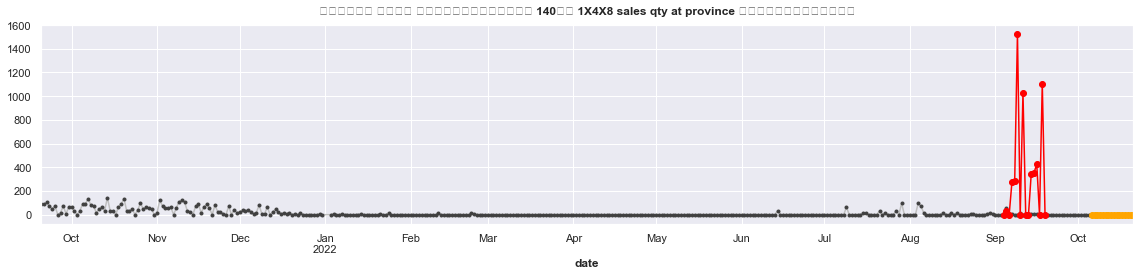

In [ ]:
provincename = 'กรุงเทพมหานคร'
productnameth = 'คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8'

# provincename = 'จ.แม่ฮ่องสอน'  
# productnameth = 'ยันฮี น้ำกัญชา 460มล 1x12' 

ax = y.loc(axis=1)[provincename, productnameth].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[provincename, productnameth].plot(ax=ax, marker='.', color='red', markersize=12)
ax = y_forecast.loc(axis=1)[provincename, productnameth].plot(ax=ax, marker='.', color='orange', markersize=12)
ax.set_title(f'{productnameth} sales qty at province {provincename}');

# LSTM (kernel dies)

In [ ]:
# X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_valid_series = X_validation.values.reshape((X_validation.shape[0], X_validation.shape[1], 1))

In [ ]:
# from keras import optimizers
# lr = 0.0003
# epochs = 10
# batch = 10
# adam = optimizers.Adam(lr)

In [ ]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model_lstm.add(Dense(1))
# model_lstm.compile(loss='mse', optimizer=adam)
# model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_validation), epochs=epochs, verbose=2)